### Imports

In [47]:
import pandas as pd
import re
import itertools   
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from spacy.lang.en import English
from booknlp.booknlp import BookNLP
from IPython.core.pylabtools import figsize
sns.set_theme(style="darkgrid")
figsize(20, 15)
pd.set_option('display.max_colwidth', None)
nlp = English()
tokenizer = nlp.tokenizer


### Survey data and stories

In [48]:
def get_indexes(raw):
   if( not pd.isna(raw)):
      highlights = re.findall(r'\d+:', raw)
      return list(map(lambda x: int(x.replace(':', '')) - 1, highlights))

In [49]:
data_unfiltered = pd.read_csv('survey_responses.csv')
data = data_unfiltered[(data_unfiltered['aphantasia_check'] == '5') | (data_unfiltered['aphantasia_check'] == '6')]
# data = data_unfiltered[(data_unfiltered['hours_read'] != '0-1 hours')]
data = data.drop(['StartDate', 'ResponseId', 'EndDate', 'IPAddress', 'Progress', 'Duration (in seconds)', 'RecipientLastName', 'RecipientFirstName', 'RecipientEmail', 'ExternalReference', 'LocationLatitude', 'LocationLongitude', 'DistributionChannel', 'Q_RecaptchaScore', 'UserLanguage'], axis=1)[data['Finished'] == 'True']
data['highlight_hp_high_1'] = data['highlight_hp_high_1'].map(get_indexes)
data['highlight_hp_high_2'] = data['highlight_hp_high_2'].map(get_indexes)
data['highlight_hp_low_1'] = data['highlight_hp_low_1'].map(get_indexes)
data['highlight_hp_low_2'] = data['highlight_hp_low_2'].map(get_indexes)
data['highlight_hero_high_1'] = data['highlight_hero_high_1'].map(get_indexes)
data['highlight_hero_high_2'] = data['highlight_hero_high_2'].map(get_indexes)
data['highlight_hero_low_1'] = data['highlight_hero_low_1'].map(get_indexes)
data['highlight_hero_low_2'] = data['highlight_hero_low_2'].map(get_indexes)

In [50]:
hp_high_sentences = list(open('hp_high.txt', 'r').read().split('\n'))
hp_low_sentences = list(open('hp_low.txt', 'r').read().split('\n'))
hero_high_sentences = list(open('hero_high.txt', 'r').read().split('\n'))
hero_low_sentences = list(open('hero_low.txt', 'r').read().split('\n'))


In [51]:
all_stories = ['hp_high', 'hp_low', 'hero_high', 'hero_low']
all_sentences = [hp_high_sentences, hp_low_sentences, hero_high_sentences, hero_low_sentences]

### Utility functions

In [52]:
def group_highlights(sent, highlights):
   highlight_array = np.zeros(len(sent))
   for x in highlights:
      if(x != None):
         highlight_array[x] += 1
   return highlight_array

In [53]:
def get_highlight_text(sent, bool_array):
   return [sent[i] for i in np.where(bool_array)[0]]

In [54]:
def show_highlight_results(storyName, sentences, data):
   column_inc = f"highlight_{storyName}_1"
   column_dec = f"highlight_{storyName}_2"
   y1 = group_highlights(sentences, data[column_inc])
   y2 = group_highlights(sentences, data[column_dec])

   return (y1, y2)

In [55]:
def get_sentence(num, story):
   story_tokens = tokens[story]
   row = story_tokens[story_tokens['token_ID_within_document'] == num]['sentence_ID']
   if(len(row) > 0):
      return story_tokens[story_tokens['token_ID_within_document'] == num]['sentence_ID'].iloc[0]
   else:
      return -1

In [56]:
def get_supersense(story):
   supersense_df = pd.read_csv(f"results/{story}/{story}.supersense", delimiter='\t')
   story_list = list(itertools.repeat(story, len(supersense_df['start_token'])))
   supersense_df['sentence'] = list(map(get_sentence, supersense_df['start_token'], story_list))
   return supersense_df

In [57]:
def count_cognition_words(supersense, sent):
   cognition_counts = np.zeros(len(sent))
   for i in range(len(sent)):
      supersense_tokens = supersense[supersense['sentence'] == i]['supersense_category']
      for j in supersense_tokens:
         if(j == 'noun.cognition' or j == 'verb.cognition'):
            cognition_counts[i] += 1
   return cognition_counts

In [58]:
def get_concreteness_scores(sentence):
   tokens = tokenizer(sentence)
   score = 0
   for token in tokens:
      row = concreteness_scores[concreteness_scores['Word'] == str(token)]
      if(len(row) > 0):
         score = score + row['Conc.M'].iloc[0]
   return score / len(tokens)

### Process highlights

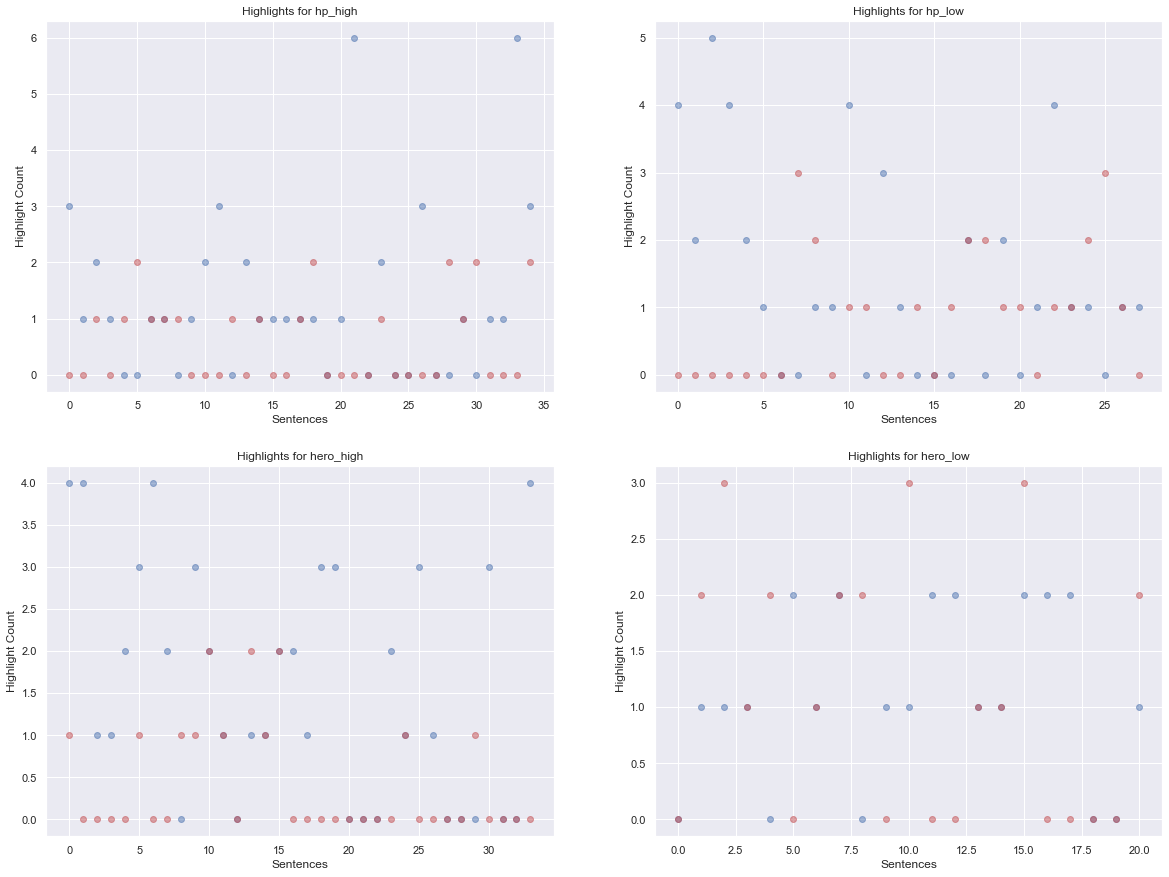

In [59]:
counts_inc = dict(zip(all_stories, np.zeros(len(all_stories))))
counts_dec = dict(zip(all_stories, np.zeros(len(all_stories))))
sentence_counts = dict(zip(all_stories, np.zeros(len(all_stories))))
sentences = dict(zip(all_stories, all_sentences))
fig, ax = plt.subplots(2, 2)
count = 0
axes = [[0, 0], [0, 1], [1, 0], [1, 1]]

for story in all_stories:
   counts_inc[story], counts_dec[story] = show_highlight_results(story, sentences[story], data) # show individual results by passing in a row: data[1:2]
   sentence_counts[story] = pd.DataFrame(sentences[story], columns=['sentence'])
   sentence_counts[story]['increase'] = counts_inc[story]
   sentence_counts[story]['decrease'] = counts_dec[story]
   # display(sentence_counts[story].head())
   # Plot the highlights
   x = np.linspace(0, len(sentences[story]) -1, len(sentences[story]))
   ax1 = axes[count][0]
   ax2 = axes[count][1]
   ax[ax1, ax2].scatter(x, counts_inc[story], alpha=.5, color='b')
   ax[ax1, ax2].scatter(x, counts_dec[story], alpha=.5, color='r')
   ax[ax1, ax2].set_xlabel("Sentences")
   ax[ax1, ax2].set_ylabel("Highlight Count")
   ax[ax1, ax2].set_title(f"Highlights for {all_stories[count]}")

   count +=1
plt.show()


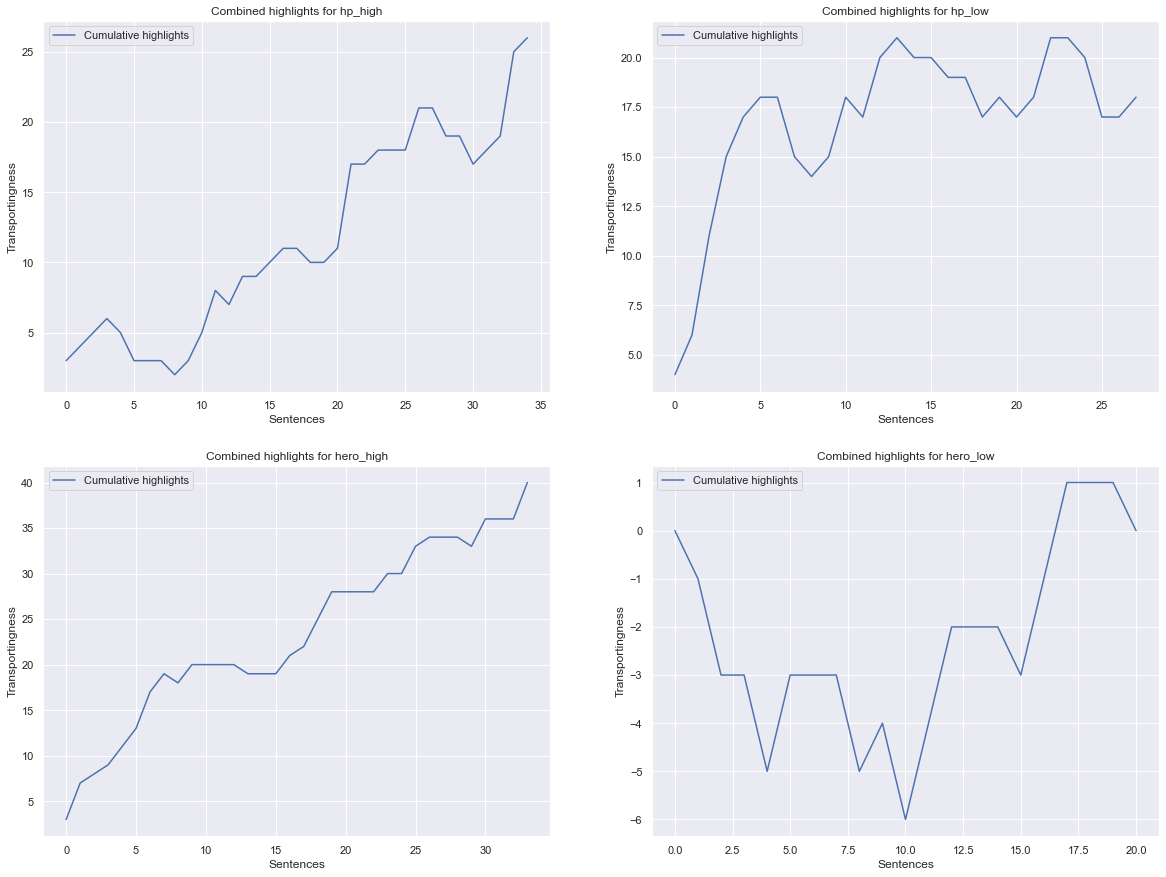

In [60]:


fig, ax = plt.subplots(2, 2)
count = 0
combined_highlights = dict(zip(all_stories, np.zeros(len(all_stories))))

for story in all_stories:
   combined_highlights[story] = counts_inc[story] - counts_dec[story]

   cdf = np.cumsum(combined_highlights[story])
   # Plot the highlights
   x = np.linspace(0, len(sentences[story]) -1, len(sentences[story]))
   ax1 = axes[count][0]
   ax2 = axes[count][1]
   ax[ax1, ax2].plot(x, cdf, color='b', label="Cumulative highlights")
   ax[ax1, ax2].set_xlabel("Sentences")
   ax[ax1, ax2].set_ylabel("Transportingness")
   ax[ax1, ax2].set_title(f"Combined highlights for {all_stories[count]}")
   ax[ax1, ax2].legend()
   count +=1

plt.show()

In [61]:
questions = pd.read_csv('survey_responses.csv')[0:1]

In [62]:
scale_questions = ['emotional_affect', 'forgetting_surroundings', 'distracted', 'characters_alive', 'mental_imagery']

### BookNLP, LIWC, and Concreteness data

In [63]:
def run_booknlp(story):
	model_params={
			"pipeline":"entity,quote,supersense,event,coref", 
			"model":"big"
		}
		
	booknlp=BookNLP("en", model_params)

	# Input file to process
	input_file=f"{story}.txt"

	# Output directory to store resulting files in
	output_directory=f"results/{story}"

	# File within this directory will be named ${book_id}.entities, ${book_id}.tokens, etc.
	book_id=story

	booknlp.process(input_file, output_directory, book_id)

In [64]:
# for story in all_stories:
#    run_booknlp(story)

In [65]:
concreteness_scores = pd.read_csv("concreteness_scores.csv")
liwc = pd.read_csv('liwc_results.csv')

In [72]:
tokens = dict(zip(all_stories, np.zeros(len(all_stories))))
supersense = dict(zip(all_stories, np.zeros(len(all_stories))))
sentiment = dict(zip(all_stories, np.zeros(len(all_stories))))
pairplot_df = dict(zip(all_stories, np.zeros(len(all_stories))))

for story in all_stories:
   tokens[story] = pd.read_csv(f"results/{story}/{story}.tokens", delimiter='\t')
   supersense[story] = get_supersense(story)
   sentiment[story] = pd.read_csv(f"feature_results/sentiment/{story}_sent.csv")['sentiment']
   sentence_counts[story]['cognition'] = count_cognition_words(supersense[story], sentences[story])
   sentence_counts[story]['perception'] = list(liwc[liwc['Filename'] == f'{story}.txt']['Perception'])
   sentence_counts[story]['concreteness'] = list(map(get_concreteness_scores, sentences[story]))
   sentence_counts[story]['sentiment'] = list(sentiment[story])
   sentence_counts[story]['sentiment_non_neutral'] = list(map(lambda x: 1 if abs(x) > 0 else 0, (sentiment[story])))
   pairplot_df[story] = sentence_counts[story].drop('sentence', axis=1)


<img src="perception.png" width="50%" height="50%">

### Compute Correlations

In [73]:
pairplot_df['hero_high'].head()

,increase,decrease,cognition,perception,concreteness,sentiment,sentiment_non_neutral
0,4.0,1.0,0.0,5.26,1.902174,0.0,0
1,4.0,0.0,0.0,42.11,2.415238,0.0,0
2,1.0,0.0,0.0,0.00,0.911429,1.0,1
3,1.0,0.0,0.0,0.00,1.172000,0.0,0
4,2.0,0.0,0.0,0.00,0.690000,1.0,1


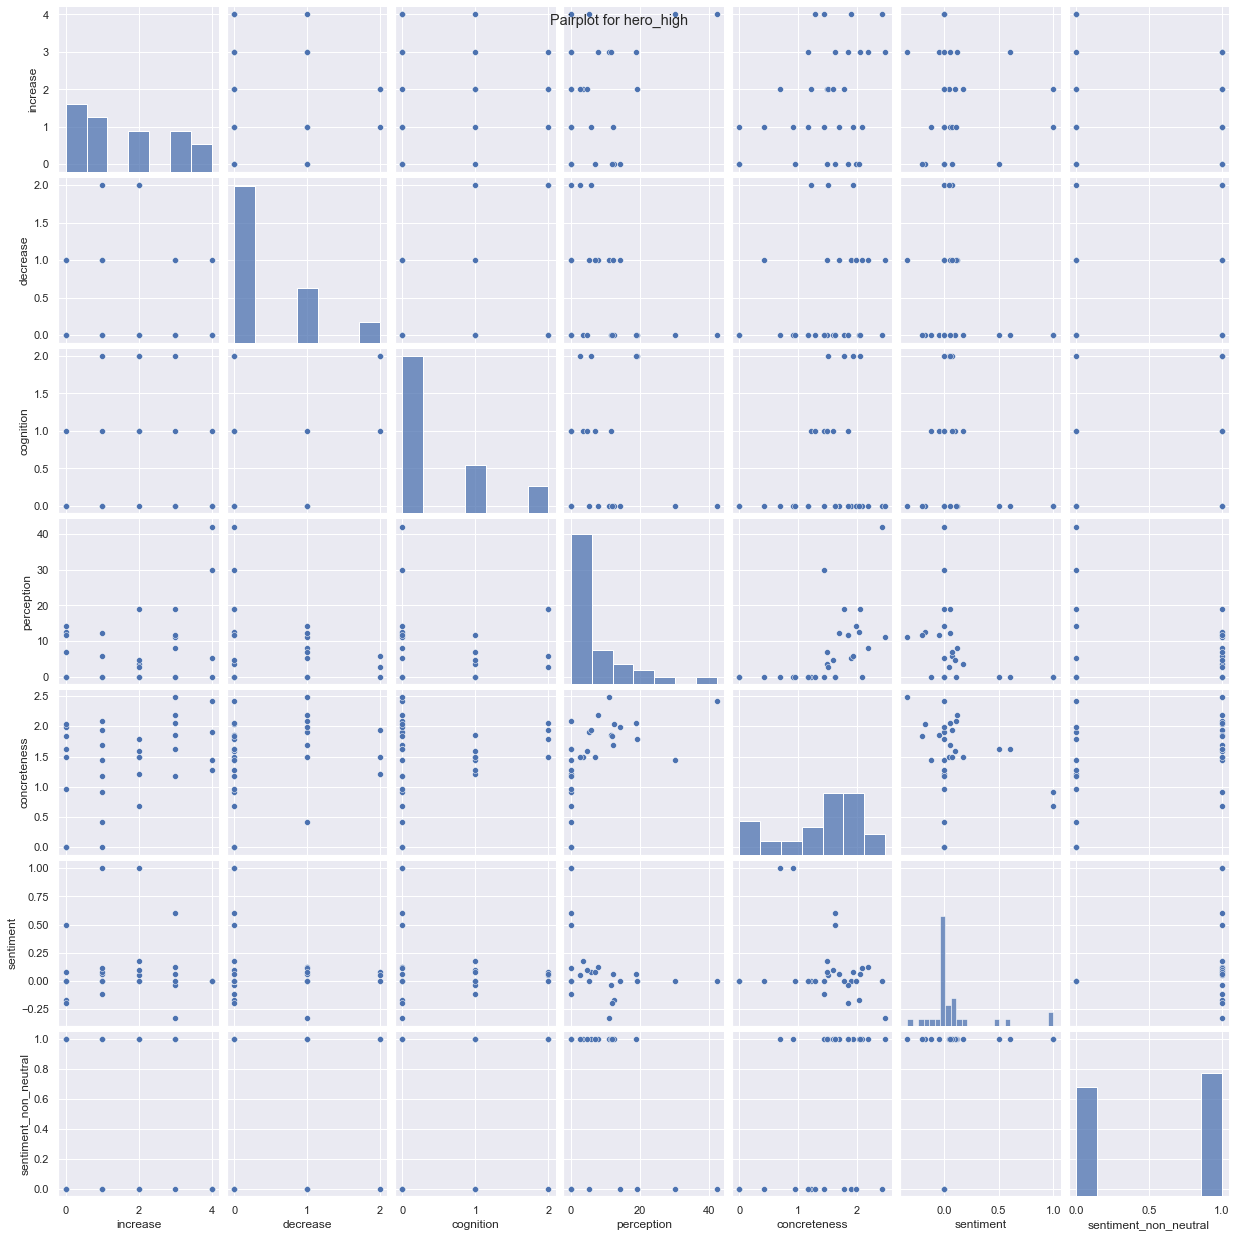

In [74]:
story_pairplot = sns.pairplot(pairplot_df['hero_high'])
story_pairplot.fig.suptitle(f"Pairplot for hero_high")
plt.show()

Correlation for hp_high


,increase,decrease,cognition,perception,concreteness,sentiment,sentiment_non_neutral
increase,1.000000,-2.446931e-01,-1.535625e-01,0.214185,0.469927,-0.220161,0.393860
decrease,-0.244693,1.000000e+00,4.354653e-17,0.064950,0.163581,0.193882,0.127562
cognition,-0.153562,4.354653e-17,1.000000e+00,-0.266861,0.115714,0.124353,0.059131
perception,0.214185,6.494972e-02,-2.668613e-01,1.000000,0.172344,0.022707,-0.116453
concreteness,0.469927,1.635807e-01,1.157141e-01,0.172344,1.000000,-0.078300,0.183212
sentiment,-0.220161,1.938821e-01,1.243533e-01,0.022707,-0.078300,1.000000,-0.238119
sentiment_non_neutral,0.393860,1.275625e-01,5.913124e-02,-0.116453,0.183212,-0.238119,1.000000


Correlation for hp_low


,increase,decrease,cognition,perception,concreteness,sentiment,sentiment_non_neutral
increase,1.000000,-0.351092,-0.429457,0.167883,0.100417,-0.378341,-0.001706
decrease,-0.351092,1.000000,0.114793,-0.368074,0.092660,-0.035695,0.333516
cognition,-0.429457,0.114793,1.000000,-0.244645,-0.003719,0.272251,0.088716
perception,0.167883,-0.368074,-0.244645,1.000000,0.427456,-0.220874,-0.096873
concreteness,0.100417,0.092660,-0.003719,0.427456,1.000000,-0.319147,0.022580
sentiment,-0.378341,-0.035695,0.272251,-0.220874,-0.319147,1.000000,-0.212148
sentiment_non_neutral,-0.001706,0.333516,0.088716,-0.096873,0.022580,-0.212148,1.000000


Correlation for hero_high


,increase,decrease,cognition,perception,concreteness,sentiment,sentiment_non_neutral
increase,1.000000,0.025289,0.190399,0.417909,0.444920,0.009892,-0.025218
decrease,0.025289,1.000000,0.315859,-0.077374,0.282939,-0.158658,0.144635
cognition,0.190399,0.315859,1.000000,0.099706,0.265022,-0.118964,0.259663
perception,0.417909,-0.077374,0.099706,1.000000,0.551471,-0.261535,-0.043862
concreteness,0.444920,0.282939,0.265022,0.551471,1.000000,-0.160523,0.495056
sentiment,0.009892,-0.158658,-0.118964,-0.261535,-0.160523,1.000000,0.307893
sentiment_non_neutral,-0.025218,0.144635,0.259663,-0.043862,0.495056,0.307893,1.000000


Correlation for hero_low


,increase,decrease,cognition,perception,concreteness,sentiment,sentiment_non_neutral
increase,1.000000,-0.068189,0.031133,0.212205,0.465050,-0.212807,0.223315
decrease,-0.068189,1.000000,0.374864,0.007435,0.214246,-0.011741,-0.286489
cognition,0.031133,0.374864,1.000000,-0.176266,0.126493,-0.058266,-0.118913
perception,0.212205,0.007435,-0.176266,1.000000,0.350709,-0.228583,-0.032327
concreteness,0.465050,0.214246,0.126493,0.350709,1.000000,-0.036960,0.310537
sentiment,-0.212807,-0.011741,-0.058266,-0.228583,-0.036960,1.000000,0.046117
sentiment_non_neutral,0.223315,-0.286489,-0.118913,-0.032327,0.310537,0.046117,1.000000


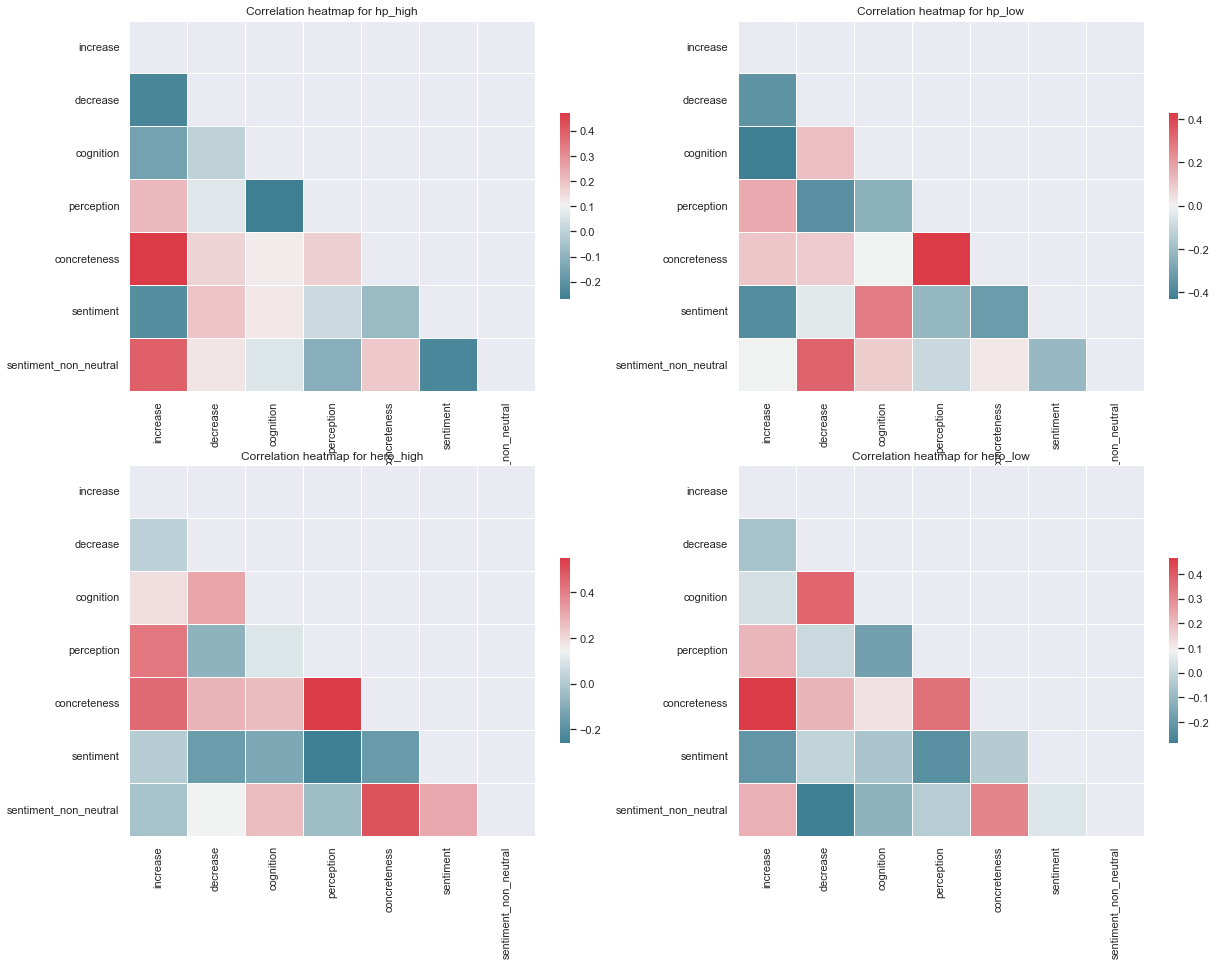

In [75]:
corr = dict(zip(all_stories, np.zeros(len(all_stories))))
f, ax = plt.subplots(2, 2)
count = 0
axes = [[0, 0], [0, 1], [1, 0], [1, 1]]

for story in all_stories:
    ax1 = axes[count][0]
    ax2 = axes[count][1]

    # Compute the correlation matrix
    corr[story] = pairplot_df[story].corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr[story], dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(
        corr[story],
        mask=mask,
        cmap=cmap,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
        ax=ax[ax1, ax2]
    )
    ax[ax1, ax2].set_title(f"Correlation heatmap for {story}")
    print(f"Correlation for {story}")
    display(corr[story])
    count += 1

plt.show()

